In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

from clim_utils import daily_climo_subx

In [2]:
base_path='/glade/scratch/kpegion/ESPWG/data/'

In [3]:
def preproc(ds):
    

    if (len(ds['time'])<34):
              
        ds['lat']=(np.arange(-90,91))
        
        tmpdata=np.zeros((34,len(ds['lat']),len(ds['lon'])))
        tmpdata[:,:,:]=np.nan
        ds_tmp=xr.DataArray(tmpdata,
                            coords={'time': np.arange(0,34).astype('float64'), 
                                    'lat':ds['lat'].astype('float32'),
                                    'lon': ds['lon'].astype('float32')},
                            dims=['time', 'lat','lon'])        
        ds=ds_tmp.to_dataset(name='tas_2m')
        
    else:                          
        ds=ds.isel(time=slice(0,34))
    
    return ds

### Get Weekly FCST Anomalies for WACCM hindcasts

In [4]:
path='/glade/p/nsc/ncgd0042/ssfcst/70Lwaccm6/p1/'
model='70Lwaccm6'
varname='tas_2m'
enss=['00','01','02','03'] #,'04']
sdate='19990104'
edate='20151231'

#mnums=['01','02','12']
#mstrs=['jan','feb','dec']

mnums=['01','02','12']
mstrs=['jan','feb','dec']

#mnums=['12'] #,'02']
#mstrs=['dec'] #,'feb']


yrs_list=np.arange(1999,2016) 
yrs_list

array([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015])

In [5]:
# Create empty list to append date for each ensemble member to
fcst_ds_ens=[]

# Loop over ensembles
for iens in enss:

    fcst_ds_months=[]
    
    # Get list of files for all ICs for this ensemble member
    for mnum,mstr in zip(mnums,mstrs):
        
        # Get all the filenames for this month for all years
        fnames = [f'{path}/{varname}/{year}/{mnum}/{varname}_{model}_*{mstr}{year}_00z_d01_d46_m{iens}.nc' for year in yrs_list]       
        files1=[]
        for files in fnames:
            f2=glob.glob(files)
            for f in f2:
                files1.append(f)
       
        # Read in data concatentating over the init dimension
        fcst_ds_tmp=xr.open_mfdataset(files1,parallel=True,combine='nested',
                                      decode_times=False,concat_dim='init',
                                      preprocess=preproc)

        # Create init dates and assign them to init dimension
        init_dates_all=pd.date_range(start=sdate,end=edate,freq='7D')
        djf_dates=init_dates_all[(init_dates_all.month==int(mnum))]
        fcst_ds_tmp['init']=djf_dates

        # Append the latest month to the list
        fcst_ds_months.append(fcst_ds_tmp)
        
    
    # Combine the months
    fcst_ds_months = xr.combine_nested(fcst_ds_months, concat_dim=['init'])
    
    # Append this ensenble member to the list
    fcst_ds_ens.append(fcst_ds_months)
    
    
fcst_ds_ens    

[<xarray.Dataset>
 Dimensions:  (init: 219, lat: 181, lon: 360, time: 34)
 Coordinates:
   * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
   * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 29.0 30.0 31.0 32.0 33.0
   * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
   * init     (init) datetime64[ns] 1999-01-04 1999-01-11 ... 2015-12-28
 Data variables:
     tas_2m   (init, time, lat, lon) float32 dask.array<chunksize=(1, 34, 181, 360), meta=np.ndarray>,
 <xarray.Dataset>
 Dimensions:  (init: 219, lat: 181, lon: 360, time: 34)
 Coordinates:
   * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
   * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 29.0 30.0 31.0 32.0 33.0
   * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
   * init     (init) datetime64[ns] 1999-01-04 1999-01-11 ... 2015-12-28
 Data variables:
     tas_2m   (init, time, lat, lon) float64 dask

In [6]:
# Combine data over ensemble dimension
fcst_ds_ens = xr.combine_nested(fcst_ds_ens, concat_dim=['ens'])
fcst_ds_ens['ens']=np.arange(0,len(enss))

fcst_ds_ens

,Array,Chunk
Bytes,15.53 GB,17.72 MB
Shape,"(4, 219, 34, 181, 360)","(1, 1, 34, 181, 360)"
Count,7860 Tasks,876 Chunks
Type,float64,numpy.ndarray


In [7]:
fcst_ds=fcst_ds_ens.mean(dim='ens')
del fcst_ds_ens

In [8]:
# Determine leads and set them as integers 
nt=fcst_ds['time'].size
leads=np.arange(0,nt)
fcst_ds=fcst_ds.rename({'time':'lead'})
fcst_ds['lead']=leads

In [9]:
# Read Climo
climo_path=base_path+model+'/hcst/climo/'
climo_fcst_fname=climo_path+'climo_'+varname+'.nc'
climo_fcst=xr.open_dataset(climo_fcst_fname,decode_times=True)

climo_fcst

<xarray.Dataset>
Dimensions:    (dayofyear: 91, lat: 181, lead: 34, lon: 360)
Coordinates:
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lead       (lead) int64 0 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33
  * lat        (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    tas_2m     (dayofyear, lead, lat, lon) float64 ...

In [10]:
# Calc Anoms
anoms_fcst=fcst_ds.groupby('init.dayofyear')-climo_fcst
anoms_fcst

,Array,Chunk
Bytes,3.88 GB,17.72 MB
Shape,"(219, 34, 181, 360)","(1, 34, 181, 360)"
Count,9922 Tasks,219 Chunks
Type,float64,numpy.ndarray


### Get the verification anomalies for Week 1 forecasts from the fcst init dates

In [11]:
varname2='tas2m'
verif_path=base_path+'verif/'
verif_dataset='CPC-TEMP'

In [12]:
# Read in verif data for 1999-2015 and calculate climo
verif_files_tmax = [f'{verif_path}{varname2}/daily/{verif_dataset}/orig/tmax.{year}.nc' for year in range(1999, 2016)]
verif_files_tmin = [f'{verif_path}{varname2}/daily/{verif_dataset}/orig/tmin.{year}.nc' for year in range(1999, 2016)]
verif_files_tmax

['/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.1999.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2000.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2001.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2002.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2003.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2004.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2005.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2006.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2007.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2008.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2009.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2010.nc',
 '/g

In [13]:
verif_ds_tmax=xr.open_mfdataset(verif_files_tmax,decode_times=True,combine='by_coords',
                                parallel=True)  
verif_ds_tmin=xr.open_mfdataset(verif_files_tmin,decode_times=True,combine='by_coords',
                                parallel=True) 

In [14]:
verif_ds_tmax=verif_ds_tmax.rename({'tmax':varname2})
verif_ds_tmin=verif_ds_tmin.rename({'tmin':varname2})
verif_ds=(verif_ds_tmax+verif_ds_tmin)*0.5
verif_ds

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 6209)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2015-12-31
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 ... 358.25 358.75 359.25 359.75
Data variables:
    tas2m    (time, lat, lon) float32 dask.array<chunksize=(365, 360, 720), meta=np.ndarray>

In [15]:
# Read Climo
verif_climo_path=verif_path+varname2+'/daily/'+verif_dataset+'/climo/'
climo_verif_fname=verif_climo_path+'climo_'+verif_dataset+'_'+varname2+'.nc'
climo_verif=xr.open_dataset(climo_verif_fname,decode_times=True)

In [16]:
# Calc Anoms
anoms_verif=verif_ds.groupby('time.dayofyear')-climo_verif

In [17]:
# Rename the variable in fcst to match verif for interpolation to work
anoms_fcst=anoms_fcst.rename({varname:varname2})

In [18]:
# Interpolate verif to fcst 1x1 grid
verif1x1=anoms_verif.interp_like(anoms_fcst)
verif1x1=verif1x1.chunk({'time':-1})
verif1x1

<xarray.Dataset>
Dimensions:    (lat: 181, lon: 360, time: 6209)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2015-12-31
    dayofyear  (time) int64 dask.array<chunksize=(6209,), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat        (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
Data variables:
    tas2m      (time, lat, lon) float64 dask.array<chunksize=(6209, 181, 360), meta=np.ndarray>

In [19]:
fcstweekly=anoms_fcst.rolling(lead=7,center=False).mean().dropna(dim='lead')

In [20]:
verifweekly=verif1x1.rolling(time=7,center=False).mean()

In [21]:
fcstweekly

,Array,Chunk
Bytes,3.20 GB,14.60 MB
Shape,"(219, 28, 181, 360)","(1, 28, 181, 360)"
Count,25471 Tasks,219 Chunks
Type,float64,numpy.ndarray


In [22]:
verifweekly

<xarray.Dataset>
Dimensions:    (lat: 181, lon: 360, time: 6209)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2015-12-31
    dayofyear  (time) int64 dask.array<chunksize=(6209,), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat        (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
Data variables:
    tas2m      (time, lat, lon) float64 dask.array<chunksize=(3, 181, 360), meta=np.ndarray>

In [23]:
nleads=fcstweekly['lead'][::7].size
fcstweeklyda=xr.DataArray(fcstweekly[varname2][:,::7,:,:],
                           coords={'init' : fcstweekly['init'],
                                   'lead': np.arange(1,nleads+1),
                                   'lat' : fcstweekly['lat'],
                                   'lon' : fcstweekly['lon']
                                   },
                           dims=['init', 'lead','lat','lon'])
fcstweeklyda.name = varname2
fcstweeklyda['lead'].attrs={'units': 'weeks'}
del fcstweekly

In [24]:
fcstweeklyda

<xarray.DataArray 'tas2m' (init: 219, lead: 4, lat: 181, lon: 360)>
array([[[[ 1.73985772,  1.73986106,  1.73986495, ...,  1.73986445,
           1.73986474,  1.73986601],
         [ 1.60315859,  1.60287859,  1.60216503, ...,  1.60346327,
           1.6031425 ,  1.60292481],
         [ 1.68389726,  1.67949501,  1.67665978, ...,  1.69102729,
           1.68856254,  1.68611723],
         ...,
         [ 0.90510904,  0.88670248,  0.86791279, ...,  0.94251759,
           0.93050591,  0.91874205],
         [ 1.07494009,  1.07418041,  1.07300543, ...,  1.07636521,
           1.07554157,  1.07525572],
         [ 0.93036014,  0.93080865,  0.93122353, ...,  0.92874602,
           0.92932601,  0.92986307]],

        [[-0.58103658, -0.5810361 , -0.58104279, ..., -0.58102572,
          -0.58101825, -0.58101259],
         [-0.6939754 , -0.69684121, -0.69899527, ..., -0.68204435,
          -0.68630885, -0.69008749],
         [-0.83759528, -0.84012581, -0.84491242, ..., -0.82435362,
          -0.82947171, -0.83263931],
         ...,
         [-1.19707392, -1.20128309, -1.20559023, ..., -1.19050902,
          -1.19224922, -1.19429967],
         [-1.12417604, -1.12455968, -1.1248164 , ..., -1.12293962,
          -1.12324508, -1.1237027 ],
         [-0.97185135, -0.97225639, -0.97263348, ..., -0.9704135 ,
          -0.97093029, -0.97140735]],

        [[-1.11973547, -1.11973663, -1.11973312, ..., -1.11971876,
          -1.11971916, -1.11972926],
         [-0.81571724, -0.80884426, -0.79954018, ..., -0.82906772,
          -0.8249496 , -0.82076518],
         [-0.36307243, -0.36362476, -0.3658522 , ..., -0.35175417,
          -0.3520494 , -0.3541028 ],
         ...,
         [ 0.23202248,  0.20455449,  0.17662489, ...,  0.29784022,
           0.27777886,  0.25623389],
         [-0.30642234, -0.31052838, -0.31487488, ..., -0.29698257,
          -0.30004441, -0.30303521],
         [-0.69021949, -0.69016926, -0.6901299 , ..., -0.69041316,
          -0.69033885, -0.69027409]],

        [[-1.78383927, -1.78383545, -1.78384004, ..., -1.78382991,
          -1.78383172, -1.78383766],
         [-2.06964649, -2.0661725 , -2.06261834, ..., -2.07459532,
          -2.07277927, -2.07122494],
         [-2.34734099, -2.34194773, -2.33587814, ..., -2.36310839,
          -2.3567935 , -2.34956052],
         ...,
         [ 3.2438732 ,  3.21625295,  3.18727649, ...,  3.32174511,
           3.29504242,  3.27011797],
         [ 2.26719038,  2.25753542,  2.24707063, ...,  2.29092983,
           2.28345864,  2.27568255],
         [ 1.35810395,  1.35906431,  1.35995928, ...,  1.35464155,
           1.35588934,  1.35704003]]],


       [[[ 1.5514838 ,  1.55148301,  1.5514876 , ...,  1.55148872,
           1.55148737,  1.55148808],
         [ 1.64943919,  1.65090765,  1.65403013, ...,  1.64171849,
           1.64448172,  1.64736414],
         [ 1.77536231,  1.77474775,  1.77735628, ...,  1.77708884,
           1.7760849 ,  1.77501679],
         ...,
         [-3.34880558, -3.33742731, -3.32634746, ..., -3.38194649,
          -3.37056909, -3.35965608],
         [-3.37429818, -3.36455263, -3.3546566 , ..., -3.40405985,
          -3.39428685, -3.38425792],
         [-3.48499198, -3.48425406, -3.48356414, ..., -3.48762307,
          -3.48668112, -3.48580465]],

        [[-0.31550377, -0.31550415, -0.31550174, ..., -0.3154823 ,
          -0.3154804 , -0.3154825 ],
         [-0.51584128, -0.51307963, -0.50959805, ..., -0.52603673,
          -0.52263507, -0.51942037],
         [-0.60515137, -0.59776139, -0.57468035, ..., -0.62787825,
          -0.62059389, -0.61331701],
         ...,
         [-0.48459653, -0.4642615 , -0.44460728, ..., -0.51895583,
          -0.50870402, -0.49757455],
         [-1.92460164, -1.91266208, -1.90032276, ..., -1.96772462,
          -1.95182519, -1.9375958 ],
         [-2.70348057, -2.70242839, -2.70145087, ..., -2.70723807,
          -2.70588977, -2.70463847]],

        [[-1.74587927, -1.74588094, -1.74587147, ..., -1.74586069,
          -1.74586167, 

### Now calculate skill

In [25]:
from climpred import HindcastEnsemble
import climpred

In [26]:
hindcast = HindcastEnsemble(fcstweeklyda)
hindcast = hindcast.add_observations(verifweekly, 'obs')

In [27]:
skill = hindcast.verify(metric='acc')
skill

<xarray.Dataset>
Dimensions:  (lat: 181, lead: 4, lon: 360)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lead     (lead) int64 1 2 3 4
Data variables:
    tas2m    (lead, lat, lon) float64 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
Attributes:
    prediction_skill:              calculated by climpred https://climpred.re...
    skill_calculated_by_function:  compute_hindcast
    number_of_initializations:     219
    metric:                        pearson_r
    comparison:                    e2o
    dim:                           time
    units:                         None
    created:                       2020-04-22 08:57:30

In [28]:
skill['tas2m'][0,:,:]

<xarray.DataArray 'tas2m' (lat: 181, lon: 360)>
dask.array<getitem, shape=(181, 360), dtype=float64, chunksize=(181, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
    lead     int64 1

/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


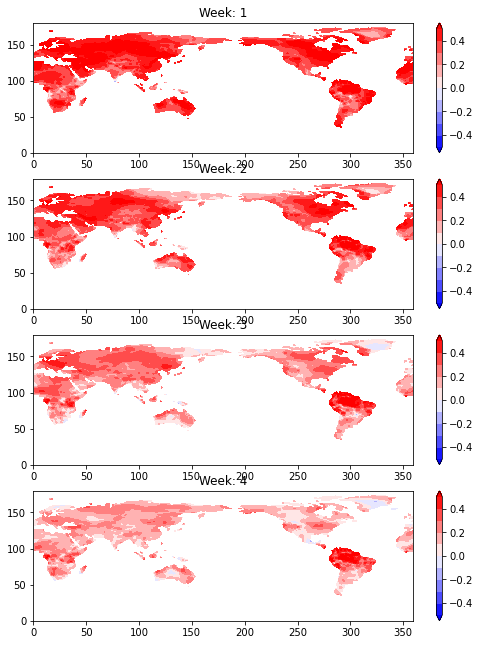

In [29]:
plt.figure(figsize=(8.5,11))
levs=np.arange(-0.5,0.6,0.1)
for iweek in np.arange(4):
    plt.subplot(4,1,iweek+1)
    plt.contourf(skill['tas2m'][iweek,:,:],levs,cmap='bwr',extend='both')
    plt.title('Week: '+(iweek+1).astype(str))
    plt.colorbar()

In [30]:
outfile=base_path+model+'/hcst/skill/'+model+'.'+varname+'.acc.emean.DJF.1999-2015.nc'
skill.to_netcdf(outfile)

/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
